<a href="https://colab.research.google.com/github/merkelmauer/mirna/blob/main/StampDIVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo
!pip install torchvision
!pip install tensorboard

In [2]:
link = '/content/drive/MyDrive/master'

# Imports

In [3]:
import sys
#sys.path.insert(0,'/content/drive/MyDrive/Marko/master')
sys.path.insert(0, link)
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.optim as optim
import torch.nn as nn
import torch.distributions as dist

from torch.nn import functional as F
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm
from tqdm import trange

#writer = SummaryWriter()
writer = None 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Classes

In [5]:
class diva_args:

    def __init__(self, zd_dim=32, zx_dim=32, zy_dim=64, d_dim=45, x_dim=7500, 
                 y_dim=2, aux_loss_multiplier_y=20, aux_loss_multiplier_d=2,
                 beta_d=10, beta_x=10, beta_y=40, 
                 rec_alpha = 1, rec_beta = 1, rec_gamma = 1):

        self.zd_dim = zd_dim
        self.zx_dim = zx_dim
        self.zy_dim = zy_dim
        self.d_dim = d_dim
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.aux_loss_multiplier_y = aux_loss_multiplier_y
        self.aux_loss_multiplier_d = aux_loss_multiplier_d
        self.beta_d = beta_d
        self.beta_x = beta_x
        self.beta_y = beta_y
        self.rec_alpha = rec_alpha
        self.rec_beta = rec_beta
        self.rec_gamma = rec_gamma


## Dataset Class

In [6]:
class MicroRNADataset(Dataset):

    def __init__(self, ds='train'):
        
        # loading images
        self.images = np.load(f'{link}/modmirbase_{ds}_images.npz')['arr_0']/255
        
        
        # loading labels
        print('Loading Labels! (~10s)')     
        ohe = OneHotEncoder(categories='auto', sparse=False)
        labels = np.load(f'{link}/modmirbase_{ds}_labels.npz')['arr_0']
        self.labels = ohe.fit_transform(labels)
        
        
        # loading names
        print('Loading Names! (~5s)')
        names =  np.load(f'{link}/modmirbase_{ds}_names.npz')['arr_0']
        names = [i.decode('utf-8') for i in names]
        self.species = ['mmu', 'prd', 'hsa', 'ptr', 'efu', 'cbn', 'gma', 'pma',
                        'cel', 'gga', 'ipu', 'ptc', 'mdo', 'cgr', 'bta', 'cin', 
                        'ppy', 'ssc', 'ath', 'cfa', 'osa', 'mtr', 'gra', 'mml',
                        'stu', 'bdi', 'rno', 'oan', 'dre', 'aca', 'eca', 'chi',
                        'bmo', 'ggo', 'aly', 'dps', 'mdm', 'ame', 'ppc', 'ssa',
                        'ppt', 'tca', 'dme', 'sbi']
        # assigning a species label to each observation from species
        # with more than 200 observations from past research
        self.names = []
        for i in names:
            append = False
            for j in self.species:
                if j in i.lower():
                    self.names.append(j)
                    append = True
                    break
            if not append:
                if 'random' in i.lower() or i.isdigit():
                    self.names.append('hsa')
                else:
                    self.names.append('notfound')
        
        # performing one hot encoding
        ohe = OneHotEncoder(categories='auto', sparse=False)
        self.names_ohe = ohe.fit_transform(np.array(self.names).reshape(-1,1))
      
    def __len__(self):
        return(self.images.shape[0])

    def __getitem__(self, idx):
        d = self.names_ohe[idx]
        y = self.labels[idx]
        x = self.images[idx]
        x = np.transpose(x, (2,0,1))
        return (x, y, d)


## Decoder classes

In [7]:
# Decoders
class px(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, zd_dim, zx_dim, zy_dim):
        super(px, self).__init__()

        self.fc1 = nn.Sequential(nn.Linear(zd_dim + zx_dim + zy_dim, 200, bias=False),  
                                 nn.ReLU())
        
        # Predicting length and color of each bar
        self.up1 = nn.Upsample(scale_factor=5)
        self.de1 = nn.Sequential(nn.ConvTranspose1d(5,25,kernel_size = 5,
                                                    stride = 1, padding = 2,
                                                    bias=False),
                                 nn.ReLU()
                                 )
        # Predicting color of each bar
        self.color_bar = nn.Sequential(nn.Conv1d(25,5, kernel_size = 3, padding = 'same'),
                                      nn.Softmax(dim=1))
        
        # Predicting the length of each bar
        self.length_bar = nn.Sequential(nn.Conv1d(25, 13, kernel_size = 3, padding = 'same'),
                                        nn.Softmax(dim=1))

        # Predicting length of the RNA strand
        self.length_RNA = nn.Sequential(nn.Linear(200,100), nn.Softmax())
        
    def forward(self, zd, zx, zy):
        if zx is None:
            zdzxzy = torch.cat((zd, zy), dim=-1)
        else:
            zdzxzy = torch.cat((zd, zx, zy), dim=-1)
        h = self.fc1(zdzxzy)
        len_RNA = self.length_RNA(h)
        
        h = h.view(-1, 5, 40)
        h = self.up1(h)
        h = self.de1(h)
        
        len_bar = self.length_bar(h)
        col_bar = self.color_bar(h)
        
        return len_RNA, len_bar, col_bar

    def reconstruct_image(self, len_RNA, len_bar, col_bar, sample=False):
        """
        reconstructs RNA image given output from decoder
        even indexes of len_bar and col_bar   -> top
        uneven indexes of len_bar and col_bar -> bottom
        function does not support sampling yet
        color reconstructions: 0: black
                               1: red
                               2: blue
                               3: green
                               4: yellow
        """
        color_dict = {
                  0: np.array([0,0,0]), # black
                  1: np.array([1,0,0]), # red
                  3: np.array([0,1,0]), # green
                  2: np.array([0,0,1]), # blue
                  4: np.array([1,1,0])  # yellow
                  }
    
        
        len_RNA = len_RNA.cpu().numpy()#.reshape((100,))
        len_bar = len_bar.cpu().numpy()
        col_bar = col_bar.cpu().numpy()
        n = len_RNA.shape[0]
        output = np.ones((n,25,100,3))

        for i in range(n):
            if sample:
                limit = np.random.choice(np.arange(100), p = len_RNA[i])
            else:
                limit = np.argmax(len_RNA[i])

            for j in range(limit+1):
                if sample:
                    _len_bar_1 = np.random.choice(np.arange(1,14), p = len_bar[i, :,2*j]) 
                    _len_bar_2 = np.random.choice(np.arange(1,14), p = len_bar[i, :, 2*j+1])
                    _col_bar_1 = np.random.choice(np.arange(5), p = col_bar[i, :, 2*j])
                    _col_bar_2 = np.random.choice(np.arange(5), p = col_bar[i,:, 2*j+1])
                else:
                    _len_bar_1 = np.argmax(len_bar[i,:, 2*j]) + 1 
                    _len_bar_2 = np.argmax(len_bar[i,:, 2*j + 1]) + 1
                    _col_bar_1 = np.argmax(col_bar[i,:, 2*j])
                    _col_bar_2 = np.argmax(col_bar[i,:, 2*j+1])
                
                h1 = 13-_len_bar_1
                # paint upper bar
                output[i, h1:13, j] = color_dict[_col_bar_1]
        
                # paint lower bar
                output[i, 13:13+_len_bar_2, j] = color_dict[_col_bar_2]
        
        
        return output

class pzd(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, zd_dim, zx_dim, zy_dim):
        super(pzd, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(d_dim, zd_dim, bias=False), 
                                 nn.BatchNorm1d(zd_dim), 
                                 nn.ReLU())
        self.fc21 = nn.Sequential(nn.Linear(zd_dim, zd_dim))
        self.fc22 = nn.Sequential(nn.Linear(zd_dim, zd_dim), nn.Softplus())

        torch.nn.init.xavier_uniform_(self.fc1[0].weight)
        torch.nn.init.xavier_uniform_(self.fc21[0].weight)
        self.fc21[0].bias.data.zero_()
        torch.nn.init.xavier_uniform_(self.fc22[0].weight)
        self.fc22[0].bias.data.zero_()

    def forward(self, d):
        hidden = self.fc1(d)
        zd_loc = self.fc21(hidden)
        zd_scale = self.fc22(hidden) + 1e-7

        return zd_loc, zd_scale


class pzy(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, zd_dim, zx_dim, zy_dim):
        super(pzy, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(y_dim, zy_dim, bias=False),
                                 nn.BatchNorm1d(zy_dim), 
                                 nn.ReLU())
        self.fc21 = nn.Sequential(nn.Linear(zy_dim, zy_dim))
        self.fc22 = nn.Sequential(nn.Linear(zy_dim, zy_dim), nn.Softplus())

        torch.nn.init.xavier_uniform_(self.fc1[0].weight)
        torch.nn.init.xavier_uniform_(self.fc21[0].weight)
        self.fc21[0].bias.data.zero_()
        torch.nn.init.xavier_uniform_(self.fc22[0].weight)
        self.fc22[0].bias.data.zero_()

    def forward(self, y):
        hidden = self.fc1(y)
        zy_loc = self.fc21(hidden)
        zy_scale = self.fc22(hidden) + 1e-7

        return zy_loc, zy_scale

In [8]:
# pzy_ = pzy(45, 7500, 2, 32,32,32)
# summary(pzy_, (1,2))
pzy_ = px(45, 7500, 2, 32,32,32)
summary(pzy_, [(1,32),(1,32),(1,32)])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Layer (type:depth-idx)                   Output Shape              Param #
px                                       --                        --
├─Sequential: 1-1                        [1, 200]                  --
│    └─Linear: 2-1                       [1, 200]                  19,200
│    └─ReLU: 2-2                         [1, 200]                  --
├─Sequential: 1-2                        [1, 100]                  --
│    └─Linear: 2-3                       [1, 100]                  20,100
│    └─Softmax: 2-4                      [1, 100]                  --
├─Upsample: 1-3                          [1, 5, 200]               --
├─Sequential: 1-4                        [1, 25, 200]              --
│    └─ConvTranspose1d: 2-5              [1, 25, 200]              625
│    └─ReLU: 2-6                         [1, 25, 200]              --
├─Sequential: 1-5                        [1, 13, 200]              --
│    └─Conv1d: 2-7                       [1, 13, 200]              988
│    

## Endcoder Classes

In [9]:
#pzy_.reconstruct_image(torch.zeros((1,100)), torch.zeros((1,13,200)), torch.zeros(1,5,200)).shape

In [10]:
class qzd(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, zd_dim, zx_dim, zy_dim):
        super(qzd, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, bias=False),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),
        )

        self.fc11 = nn.Sequential(nn.Linear(4224, zd_dim))
        self.fc12 = nn.Sequential(nn.Linear(4224, zd_dim), nn.Softplus())

        torch.nn.init.xavier_uniform_(self.encoder[0].weight)
        torch.nn.init.xavier_uniform_(self.encoder[3].weight)
        torch.nn.init.xavier_uniform_(self.fc11[0].weight)
        self.fc11[0].bias.data.zero_()
        torch.nn.init.xavier_uniform_(self.fc12[0].weight)
        self.fc12[0].bias.data.zero_()

    def forward(self, x):
        h = self.encoder(x)
        h = h.view(-1, 4224)
        zd_loc = self.fc11(h)
        zd_scale = self.fc12(h) + 1e-7

        return zd_loc, zd_scale


class qzx(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, zd_dim, zx_dim, zy_dim):
        super(qzx, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, bias=False),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),
        )

        self.fc11 = nn.Sequential(nn.Linear(4224, zx_dim))
        self.fc12 = nn.Sequential(nn.Linear(4224, zx_dim), nn.Softplus())

        torch.nn.init.xavier_uniform_(self.encoder[0].weight)
        torch.nn.init.xavier_uniform_(self.encoder[3].weight)
        torch.nn.init.xavier_uniform_(self.fc11[0].weight)
        self.fc11[0].bias.data.zero_()
        torch.nn.init.xavier_uniform_(self.fc12[0].weight)
        self.fc12[0].bias.data.zero_()

    def forward(self, x):
        h = self.encoder(x)
        h = h.view(-1, 4224)
        zd_loc = self.fc11(h)
        zd_scale = self.fc12(h) + 1e-7

        return zd_loc, zd_scale


class qzy(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, zd_dim, zx_dim, zy_dim):
        super(qzy, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, bias=False),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),
        )

        self.fc11 = nn.Sequential(nn.Linear(4224, zy_dim))
        self.fc12 = nn.Sequential(nn.Linear(4224, zy_dim), nn.Softplus())

        torch.nn.init.xavier_uniform_(self.encoder[0].weight)
        torch.nn.init.xavier_uniform_(self.encoder[3].weight)
        torch.nn.init.xavier_uniform_(self.fc11[0].weight)
        self.fc11[0].bias.data.zero_()
        torch.nn.init.xavier_uniform_(self.fc12[0].weight)
        self.fc12[0].bias.data.zero_()

    def forward(self, x):
        h = self.encoder(x)
        h = h.view(-1, 4224)
        zd_loc = self.fc11(h)
        zd_scale = self.fc12(h) + 1e-7

        return zd_loc, zd_scale

## Auxiliary predictors classes

In [11]:
# Auxiliary tasks
class qd(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, zd_dim, zx_dim, zy_dim):
        super(qd, self).__init__()

        self.fc1 = nn.Linear(zd_dim, d_dim)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc1.bias.data.zero_()

    def forward(self, zd):
        h = F.relu(zd)
        loc_d = self.fc1(h)

        return loc_d


class qy(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, zd_dim, zx_dim, zy_dim):
        super(qy, self).__init__()

        self.fc1 = nn.Linear(zy_dim, y_dim)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc1.bias.data.zero_()

    def forward(self, zy):
        h = F.relu(zy)
        loc_y = self.fc1(h)

        return loc_y

## Full model class

In [12]:
class StampDIVA(nn.Module):
    def __init__(self, args):
        super(StampDIVA, self).__init__()
        self.zd_dim = args.zd_dim
        self.zx_dim = args.zx_dim
        self.zy_dim = args.zy_dim
        self.d_dim = args.d_dim
        self.x_dim = args.x_dim
        self.y_dim = args.y_dim

        self.start_zx = self.zd_dim
        self.start_zy = self.zd_dim + self.zx_dim

        self.px = px(self.d_dim, self.x_dim, self.y_dim, self.zd_dim, self.zx_dim, self.zy_dim)
        self.pzd = pzd(self.d_dim, self.x_dim, self.y_dim, self.zd_dim, self.zx_dim, self.zy_dim)
        self.pzy = pzy(self.d_dim, self.x_dim, self.y_dim, self.zd_dim, self.zx_dim, self.zy_dim)

        self.qzd = qzd(self.d_dim, self.x_dim, self.y_dim, self.zd_dim, self.zx_dim, self.zy_dim)
        if self.zx_dim != 0:
            self.qzx = qzx(self.d_dim, self.x_dim, self.y_dim, self.zd_dim, self.zx_dim, self.zy_dim)
        self.qzy = qzy(self.d_dim, self.x_dim, self.y_dim, self.zd_dim, self.zx_dim, self.zy_dim)

        self.qd = qd(self.d_dim, self.x_dim, self.y_dim, self.zd_dim, self.zx_dim, self.zy_dim)
        self.qy = qy(self.d_dim, self.x_dim, self.y_dim, self.zd_dim, self.zx_dim, self.zy_dim)

        self.aux_loss_multiplier_y = args.aux_loss_multiplier_y
        self.aux_loss_multiplier_d = args.aux_loss_multiplier_d

        self.beta_d = args.beta_d
        self.beta_x = args.beta_x
        self.beta_y = args.beta_y

        self.rec_alpha = args.rec_alpha
        self.rec_beta = args.rec_beta
        self.rec_gamma = args.rec_gamma

        self.cuda()

    def forward(self, d, x, y):
        # Encode
        zd_q_loc, zd_q_scale = self.qzd(x)
        if self.zx_dim != 0:
            zx_q_loc, zx_q_scale = self.qzx(x)
        zy_q_loc, zy_q_scale = self.qzy(x)

        # Reparameterization trick
        qzd = dist.Normal(zd_q_loc, zd_q_scale)
        zd_q = qzd.rsample()
        if self.zx_dim != 0:
            qzx = dist.Normal(zx_q_loc, zx_q_scale)
            zx_q = qzx.rsample()
        else:
            qzx = None
            zx_q = None

        qzy = dist.Normal(zy_q_loc, zy_q_scale)
        zy_q = qzy.rsample()

        # Decode
        x_len, x_bar, x_col = self.px(zd_q, zx_q, zy_q)

        zd_p_loc, zd_p_scale = self.pzd(d)

        if self.zx_dim != 0:
            zx_p_loc, zx_p_scale = torch.zeros(zd_p_loc.size()[0], self.zx_dim).cuda(),\
                                   torch.ones(zd_p_loc.size()[0], self.zx_dim).cuda()
        zy_p_loc, zy_p_scale = self.pzy(y)

        # Reparameterization trick
        pzd = dist.Normal(zd_p_loc, zd_p_scale)
        if self.zx_dim != 0:
            pzx = dist.Normal(zx_p_loc, zx_p_scale)
        else:
            pzx = None
        pzy = dist.Normal(zy_p_loc, zy_p_scale)

        # Auxiliary losses
        d_hat = self.qd(zd_q)
        y_hat = self.qy(zy_q)

        return x_len, x_bar, x_col, d_hat, y_hat, qzd, pzd, zd_q, qzx, pzx, zx_q, qzy, pzy, zy_q

    def loss_function(self, d, x, y):
          x_len, x_bar, x_col, d_hat, y_hat, qzd, pzd, zd_q, qzx, pzx, zx_q, qzy, pzy, zy_q = self.forward(d, x, y)
          
          out_len, out_bar, out_col = self.get_encoded_values(x)
          
          CE_len = F.cross_entropy(x_len, out_len, reduction='sum')
          CE_bar = F.cross_entropy(x_bar, out_bar, reduction='sum')
          CE_col = F.cross_entropy(x_col, out_col, reduction='sum')

          zd_p_minus_zd_q = torch.sum(pzd.log_prob(zd_q) - qzd.log_prob(zd_q))
          if self.zx_dim != 0:
              KL_zx = torch.sum(pzx.log_prob(zx_q) - qzx.log_prob(zx_q))
          else:
              KL_zx = 0

          zy_p_minus_zy_q = torch.sum(pzy.log_prob(zy_q) - qzy.log_prob(zy_q))

          _, d_target = d.max(dim=1)
          CE_d = F.cross_entropy(d_hat, d_target, reduction='sum')

          _, y_target = y.max(dim=1)
          CE_y = F.cross_entropy(y_hat, y_target, reduction='sum')

          return self.rec_alpha * CE_len \
                  + self.rec_beta * CE_bar \
                  + self.rec_gamma * CE_col \
                  - self.beta_d * zd_p_minus_zd_q \
                  - self.beta_x * KL_zx \
                  - self.beta_y * zy_p_minus_zy_q \
                  + self.aux_loss_multiplier_d * CE_d \
                  + self.aux_loss_multiplier_y * CE_y,\
                  CE_y

    def get_encoded_values(self, x):
        """
        given an image or batch of images
        returns length of strand, length of bars and colors of bars
        """
        n = x.shape[0]
        out_len = torch.zeros((n,100)).to(DEVICE)
        out_col = torch.zeros((n,5,200)).to(DEVICE)
        out_bar = torch.zeros((n,13,200)).to(DEVICE)

        for i in range(n):
            rna_len = 0
            for j in range(100):
                if (x[i,:,12,j] == torch.tensor([1,1,1]).to(DEVICE)).all():
                   out_len[i,rna_len-1] = 1
                   break
                else:
                    rna_len += 1
                    # check color of bars
                    out_col[i, self.get_color(x[i,:,12,j]) ,2*j] = 1 
                    out_col[i, self.get_color(x[i,:,13,j]), 2*j+1] = 1
                    # check length of bars
                    len1 = 0
                    # loop until white pixel
                    while not (x[i,:,12-len1,j] == torch.tensor([1.,1.,1.]).to(DEVICE)).all():
                        len1 += 1
                        if 13-len1 == 0:
                           break
                    out_bar[i, len1-1, 2*j] = 1

                    len2 = 0
                    while not (x[i,:,13+len2,j] == torch.tensor([1.,1.,1.]).to(DEVICE)).all():
                        len2 += 1
                        if 13+len2 == 25:
                            break
                    out_bar[i, len2-1, 2*j+1] = 1
        return out_len, out_bar, out_col

    def get_color(self, pixel):
        """
        returns the encoded value for a pixel
        """
        if (pixel == torch.tensor([0,0,0]).to(DEVICE)).all():  
            return 0 # black
        elif (pixel == torch.tensor([1,0,0]).to(DEVICE)).all():  
            return 1 # red
        elif (pixel == torch.tensor([0,0,1]).to(DEVICE)).all():  
            return 2 # blue
        elif (pixel == torch.tensor([0,1,0]).to(DEVICE)).all():  
            return 3 # green
        elif (pixel == torch.tensor([1,1,0]).to(DEVICE)).all():  
            return 4 # yellow
        else:
            print("Something wrong!")
        
                  

    def classifier(self, x):
        """
        classify an image (or a batch of images)
        :param xs: a batch of scaled vectors of pixels from an image
        :return: a batch of the corresponding class labels (as one-hots)
        """
        with torch.no_grad():
            zd_q_loc, zd_q_scale = self.qzd(x)
            zd = zd_q_loc
            alpha = F.softmax(self.qd(zd), dim=1)

            # get the index (digit) that corresponds to
            # the maximum predicted class probability
            res, ind = torch.topk(alpha, 1)

            # convert the digit(s) to one-hot tensor(s)
            d = x.new_zeros(alpha.size())
            d = d.scatter_(1, ind, 1.0)

            zy_q_loc, zy_q_scale = self.qzy.forward(x)
            zy = zy_q_loc
            alpha = F.softmax(self.qy(zy), dim=1)

            # get the index (digit) that corresponds to
            # the maximum predicted class probability
            res, ind = torch.topk(alpha, 1)

            # convert the digit(s) to one-hot tensor(s)
            y = x.new_zeros(alpha.size())
            y = y.scatter_(1, ind, 1.0)

        return d, y

# Training the model

## Initializing model

In [13]:
default_args = diva_args(zd_dim=32, zx_dim=64, zy_dim=32,
                         aux_loss_multiplier_y=100, aux_loss_multiplier_d=2,
                         rec_alpha = 50, rec_beta = 100, rec_gamma = 100)

In [14]:
diva = StampDIVA(default_args).to(DEVICE)

In [15]:
summary(diva, [(1,45),(1,3,25,100),(1,2)])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Layer (type:depth-idx)                   Output Shape              Param #
StampDIVA                                --                        --
├─qzd: 1-1                               [1, 32]                   --
│    └─Sequential: 2-1                   [1, 64, 3, 22]            --
│    │    └─Conv2d: 3-1                  [1, 32, 21, 96]           2,400
│    │    └─ReLU: 3-2                    [1, 32, 21, 96]           --
│    │    └─MaxPool2d: 3-3               [1, 32, 10, 48]           --
│    │    └─Conv2d: 3-4                  [1, 64, 6, 44]            51,200
│    │    └─ReLU: 3-5                    [1, 64, 6, 44]            --
│    │    └─MaxPool2d: 3-6               [1, 64, 3, 22]            --
│    └─Sequential: 2-2                   [1, 32]                   --
│    │    └─Linear: 3-7                  [1, 32]                   135,200
│    └─Sequential: 2-3                   [1, 32]                   --
│    │    └─Linear: 3-8                  [1, 32]                   135,20

In [16]:
diva.load_state_dict(torch.load(f'{link}/stampdiva_v3.0.2.pth'))

<All keys matched successfully>

## Loading dataset

In [17]:
RNA_dataset = MicroRNADataset()


Loading Labels! (~10s)
Loading Names! (~5s)


In [18]:
RNA_dataset_test = MicroRNADataset('test')

Loading Labels! (~10s)
Loading Names! (~5s)


## Training functions

In [19]:
def train_single_epoch(train_loader, model, optimizer, epoch):
    model.train()
    train_loss = 0
    epoch_class_y_loss = 0

    no_batches = 0
    pbar = tqdm(enumerate(train_loader), unit="batch", 
                                     desc=f'Epoch {epoch}')
    for batch_idx, (x, y, d) in pbar:
        # To device
        # print(x)
        # print(y)
        # print(d)
        x, y, d = x.to(DEVICE), y.to(DEVICE), d.to(DEVICE)

        # if (epoch % 50 == 0) and (batch_idx == 1):
        #     save_reconstructions(model, d, x, y)

        optimizer.zero_grad()
        loss, class_y_loss = model.loss_function(d.float(), x.float(), y.float())
        _, y_pred = model.classifier(x.float())
        acc = ((y == y_pred).all(axis=1)*1.0).mean().item()
        if writer is not None:
          writer.add_scalar("Loss/train", loss, epoch)
          writer.add_scalar("y_loss/train", class_y_loss, epoch)
          writer.add_scalar("y_acc/train", acc, epoch)
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item()/x.shape[0], 
                         y_loss = class_y_loss.item()/x.shape[0])
        train_loss += loss
        epoch_class_y_loss += class_y_loss
        no_batches += 1
        # print(f'finished batch {no_batches}!')
        # if no_batches == 25:
        #     break

    train_loss /= len(train_loader.dataset)
    epoch_class_y_loss /= len(train_loader.dataset)

    return train_loss, epoch_class_y_loss

In [20]:
def test_single_epoch(test_loader, model, epoch):
    model.eval()
    test_loss = 0
    epoch_class_y_loss = 0
    test_corr = 0
        
    with torch.no_grad():
        for batch_idx, (x,y,d) in enumerate(test_loader):
            x, y, d = x.to(DEVICE), y.to(DEVICE), d.to(DEVICE)
            loss, class_y_loss = model.loss_function(d.float(), x.float(), y.float())
            _, y_pred = model.classifier(x.float())
            test_corr += (y == y_pred).all(axis=1).sum().item()
            acc = ((y == y_pred).all(axis=1)*1.).mean().item()
            if writer is not None:
              writer.add_scalar("Loss/test", loss, epoch)
              writer.add_scalar("y_loss/test", class_y_loss, epoch)
              writer.add_scalar("y_acc/test", acc, epoch)
            test_loss += loss
            epoch_class_y_loss += class_y_loss
    test_loss /= len(test_loader.dataset)
    epoch_class_y_loss /= len(test_loader.dataset)
    acc = test_corr/len(test_loader.dataset)

    return test_loss, epoch_class_y_loss, acc
  

In [21]:
def train(train_loader, diva, optimizer, end_epoch, start_epoch=0):
    epoch_loss_sup = []
    epoch_loss_y = []

    y_loss_test = []
    test_loss = []
    test_acc_lst = []

    for epoch in range(start_epoch+1, end_epoch+1):
        avg_epoch_losses_sup, avg_epoch_class_y_loss = train_single_epoch(train_loader, diva, optimizer, epoch)
        str_loss_sup = avg_epoch_losses_sup
        epoch_loss_sup.append(avg_epoch_losses_sup)
        epoch_loss_y.append(avg_epoch_class_y_loss)
        str_print = "epoch {}: avg train loss {}".format(epoch, str_loss_sup)
        str_print += ", class y train loss {}".format(avg_epoch_class_y_loss)
        print(str_print)

        test_lss, epoch_class_y_loss_test, test_acc = test_single_epoch(test_loader, diva, epoch)
        test_loss.append(test_lss)
        y_loss_test.append(epoch_class_y_loss_test)
        test_acc_lst.append(test_acc)
        str_print = "epoch {}: avg test loss {}".format(epoch, test_lss)
        str_print += ", class y test loss {}".format(epoch_class_y_loss_test)
        str_print += ", test accuracy {}".format(test_acc)
        print(str_print)
    if writer is not None:    
      writer.flush()
    return epoch_loss_sup, epoch_loss_y

## Model Training

In [22]:
train_loader = DataLoader(RNA_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(RNA_dataset_test, batch_size=128)

In [23]:
optimizer = optim.Adam(diva.parameters(), lr=0.0005)

In [24]:
lss, eplss = train(train_loader, diva, optimizer, 7, 5)

Epoch 6: 0batch [00:00, ?batch/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Epoch 6: 272batch [45:39, 10.07s/batch, loss=4.45e+4, y_loss=0.41]


epoch 6: avg train loss 41661.75390625, class y train loss 0.45483437180519104
epoch 6: avg test loss 41588.2265625, class y test loss 0.4445858597755432, test accuracy 0.8555876621194812


Epoch 7: 272batch [45:27, 10.03s/batch, loss=3.99e+4, y_loss=0.27]


epoch 7: avg train loss 41470.96484375, class y train loss 0.41649219393730164
epoch 7: avg test loss 41282.8828125, class y test loss 0.40967127680778503, test accuracy 0.9122370808413413


In [25]:
torch.save(diva.state_dict(), f'{link}/stampdiva_v3.0.2.pth')

In [26]:
lss, eplss = train(train_loader, diva, optimizer, 8, 7)

Epoch 8: 0batch [00:00, ?batch/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Epoch 8: 272batch [45:21, 10.01s/batch, loss=4.2e+4, y_loss=0.519]


epoch 8: avg train loss 41169.57421875, class y train loss 0.390360563993454
epoch 8: avg test loss 41081.05078125, class y test loss 0.4185554087162018, test accuracy 0.9246690410590687


In [27]:
torch.save(diva.state_dict(), f'{link}/stampdiva_v3.0.3.pth')

# Model Evaluation

## Sampling from trained model

In [28]:
a = next(enumerate(test_loader))

In [29]:
with torch.no_grad():
    diva.eval()
    d = a[1][2][:9].to(DEVICE).float()
    x = a[1][0][:9].to(DEVICE).float()
    y = a[1][1][:9].to(DEVICE).float()
    x_1, x_2, x_3, _, _, _, _, _, _, _, _, _, _, _ = diva(d,x,y)
    out = diva.px.reconstruct_image(x_1, x_2, x_3)
    #sample_x = sample(x_recon.cpu().numpy(), True)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


<Figure size 3600x3600 with 0 Axes>

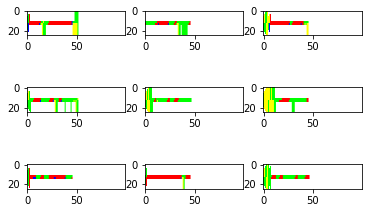

In [30]:
plt.figure(figsize=(50,50))
fig, ax = plt.subplots(nrows=3, ncols=3)
for i in range(9):
  ax[i//3, i%3].imshow(out[i])
plt.savefig('divastamprecon.png')

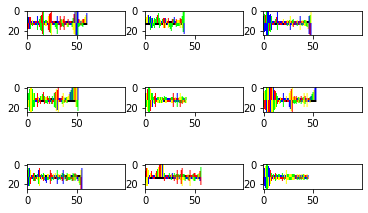

In [31]:
fig, ax = plt.subplots(nrows=3, ncols=3)
for i in range(9):
  ax[i//3, i%3].imshow(x[i].cpu().permute(1,2,0))
  
plt.savefig('divastamporg.png')